# Riconoscimento di animali per auto a guida autonoma

**VisionTech Solutions** vuole sviluppare un sistema di riconoscimento automatico delle immagini per distinguere tra veicoli e animali, con l'obiettivo di ottimizzare le operazioni di monitoraggio della fauna nelle aree urbane, evitando incidenti stradali e proteggendo sia gli animali che i veicoli.

VisionTech Solutions collabora con le amministrazioni comunali per implementare un sistema di monitoraggio in tempo reale nelle città, utilizzando telecamere installate lungo le strade per identificare e classificare veicoli e animali. Questo sistema aiuterà a prevenire incidenti stradali causati dall'attraversamento improvviso di animali, avvisando i guidatori tramite segnali stradali elettronici.

I benefici del sistema sono i seguenti

1. Automazione dei Processi:
> * Riduzione del tempo e delle risorse per monitorare manualmente le aree urbane.
> * Rilevamento automatico e in tempo reale di animali e veicoli.

2. Aumento della Precisione:
> * Utilizzo di una rete neurale convoluzionale (CNN) per garantire alta precisione nella classificazione delle immagini.
> * Minimizzazione degli errori umani.

3. Efficienza Operativa:
> * Processamento rapido e accurato di grandi volumi di dati, migliorando la risposta agli eventi.
> * Maggiore sicurezza per i cittadini e riduzione dei danni ai veicoli.

4. Applicazioni Multiple:
> * Sorveglianza e monitoraggio del traffico.
> * Analisi del comportamento animale nelle aree urbane.
> * utilizzo dei dati per migliorare le politiche di sicurezza stradale.

## Dettagli del Progetto

**Dataset**:
Utilizzo del dataset CIFAR, contenente migliaia di immagini etichettate in varie categorie, inclusi veicoli e animali.

**Algoritmo**:
Rete neurale convoluzionale (CNN) per l'analisi e la classificazione delle immagini.

**Output**:
Il sistema classificherà correttamente ogni immagine come veicolo o animale.

## 1. Importazione delle librerie

Di seguito vi è una breve spiegazione delle librerie importate per il progetto:
* **Warnings** e **os**, utili rispettivamente per gestire o sopprimere avvisi durante l’esecuzione e per operazioni legate al file system.

* **json**, usato per salvare o leggere configurazioni e risultati in formato JSON.

* **Pandas**, usata per manipolare e analizzare dati strutturati (DataFrame, tabelle).

* **NumPy**, fondamentale per operazioni numeriche e matriciali.

* **Matplotlib**, libreria base per creare grafici per la visualizzazione dei dati.

* **Seaborn**, estensione di Matplotlib dedicata a visualizzazioni statistiche più curate e intuitive.

* **Scikit-learn**, sfruttato per metriche di valutazione (accuratezza, classification report, confusion matrix), calcolo dei pesi di classe e tecniche di resampling.

* **collections.Counter**, utile per analizzare rapidamente la distribuzione delle classi o il conteggio di elementi in collezioni.

* **TensorFlow** e **Keras**, utilizzate per costruire, addestrare e valutare modelli di deep learning; includono livelli, ottimizzatori, funzioni di perdita e strumenti avanzati per il training.

* Tutti i moduli Keras specifici (_InputLayer_, _Conv2D_, _Dense_, _Dropout_, ecc.) forniscono i blocchi fondamentali per definire l’architettura della rete neurale, mentre i callback come _EarlyStopping_, _ReduceLROnPlateau_ e _ModelCheckpoint_ permettono un controllo fine sul processo di addestramento e sulla prevenzione dell’overfitting.

In [1]:
import warnings
import os
import json

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns

from tensorflow.keras import Sequential, Model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import (InputLayer, Input, Dense, Conv2D,
                                      MaxPooling2D, BatchNormalization, Flatten, Dropout,
                                      GlobalAveragePooling2D, ReLU, Add)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, class_weight


from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_path = "/content/drive/MyDrive/Colab Notebooks"

## 2. Soppressione dei warnings

Le seguenti istruzioni evitano la stampa di un numero eccessivo di warnings, il quale potrebbe risultare fastidioso e inutile al fine dello svolgimento del progetto.

In [2]:
warnings.filterwarnings("ignore") # Questa istruzione fa sì che vengano ignorati i messaggi di warning di Python

La variabile `TF_CPP_MIN_LOG_LEVEL` controlla il livello minimo livello minimo di log mostrati dalle componenti C++ di TensorFlow. La seguente istruzione imposta il livello 3, che nasconde i messaggi di tipo `INFO`, `WARNING` ed `ERROR`, lasciando solo i log più critici.

In [3]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

La seguente funzione limita il livello di verbosità degli avvisi di TensorFlow gestiti dal sistema di logging di compatibilità v1. Viene settato a `ERROR`, per evitare messaggi di gravità minore come `INFO` e `WARNING`.

In [4]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## 3. Caricamento e analisi esplorativa dei dati

### 3.1 Il dataset CIFAR

CIFAR (Canadian Institute For Advanced Research) è una famiglia di dataset di immagini a colori, ampiamente utilizzati come benchmark in computer vision per la classificazione automatica. Le immagini contenute sono di 32x32 pixel, con 3 canali (RGB). I dataset appartenenti a CIFAR sono:


**CIFAR-10**
- 60.000 immagini divise in 10 classi
- 6.000 esempi per ogni classe
- Nessuna gerarchia di classi (tutte "fine")

**CIFAR-100**
- 60.000 immagini divise in 100 classi
- 600 esempi per ogni classe
- Presente una gerarchia: 100 classi raggruppate in superclassi
- Ogni immagine ha due etichette: "coarse" (superclasse) e "fine" (sottoclasse)

#### Riassunto

| Dataset   | Immagini | Classi | Esempi per classe | Gerarchia |
|-----------|----------|--------|-------------------|-----------|
| CIFAR-10  | 60.000   | 10     | 6.000             | No        |
| CIFAR-100 | 60.000   | 100    | 600               | Sì        |


### 3.2 Analisi esplorativa dei dataset CIFAR

In questa sottosezione si procederà a un'iniziale analisi esplorativa sulle classi dei due dataset CIFAR al fine di determinare quale sia la scelta migliore per l'applicazione al contesto di questo progetto. Prima di scaricare i dataset, viene creata la funzione esplorativa `plot_images` che seleziona casualmente un numero di immagini all'interno di un dataset per poi stamparle con la loro etichetta come titolo.

In [5]:
def show_random_examples_per_class(dataset, num_per_class=5, classes=None):
    """
    Visualizza un dato numero di immagini casuali all'interno di un dataset per ogni classe specificata

    dataset
    num_per_class: numero di immagini per classe
    images: array di immagini
    classes: lista dei nomi delle classi da stampare
    """
    if classes is not None:

        images, labels = dataset

        fig, axes = plt.subplots(len(classes), num_per_class, figsize=(num_per_class * 2, len(classes) * 2))

        ax_idx = 0
        for class_name, label in classes.items():

            idx = np.where(labels.flatten() == label)[0]
            sel = np.random.choice(idx, size=num_per_class, replace=False)

            for j, s in enumerate(sel):
                ax = axes[ax_idx, j] if len(classes) > 1 else axes[j]
                ax.imshow(images[s])
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_title(class_name, fontsize=8)

            ax_idx += 1

        plt.tight_layout()
        plt.show()

La funzione precedente deve ricevere un dizionario che mappa i nomi delle classe nelle loro etichette numeriche. Di seguito viene scritta una funzione per generare automaticamente tale dizionario date le classi disponibili e quelle selezionate.

In [6]:
def get_selected_classes_dictionary(available_classes, selected):
    """
    Restituisce un dizionario che associa i nomi delle classi alle loro etichette numeriche

    available_classes: lista con i nomi delle classi disponibili in un dataset
    selected: lista delle classi selezionate
    """

    unavailable_classes = [cls for cls in selected if cls not in available_classes]
    if unavailable_classes:
        raise ValueError(
            f"The following classes are not available: {unavailable_classes}. "
            f"Available classes: {available_classes}"
        )

    return {name: available_classes.index(name) for name in selected}

Tramite il modulo `datasets` di `keras` è possibile scaricare i dataset.

#### CIFAR10

Di seguito, viene riportata la lista delle 10 etichette presenti nel dataset, presa direttamente dal sito ufficiale del dataset.

In [7]:
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
(x10_train, y10_train), (x10_test, y10_test) = tf.keras.datasets.cifar10.load_data()

La mappatura delle classi è presente sul sito ufficiale del dataset.

In [9]:
np.unique(y10_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [10]:
np.unique(y10_test, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

Il dataset contiene dieci categorie:
- sei categorie di animali: uccello, cane, gatto, cervo, rana, cavallo)
- quattro di veicoli: (automobile, aereoplano, nave, camion)

Le categorie sono tutte perfettamente bilanciate, sia tra di loro che nella suddivisione train test. Come si può notare, il dataset è già focalizzato sul dominio specifico del progetto: classificazione di veicoli e animali. Per ogni categoria c'è un'abbondante numero di immagini di addestramento (5000).

In [11]:
classes_dictionary = get_selected_classes_dictionary(cifar10_labels, selected=['bird', 'cat', 'deer', 'dog', 'frog', 'horse'])

In [12]:
classes_dictionary

{'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7}

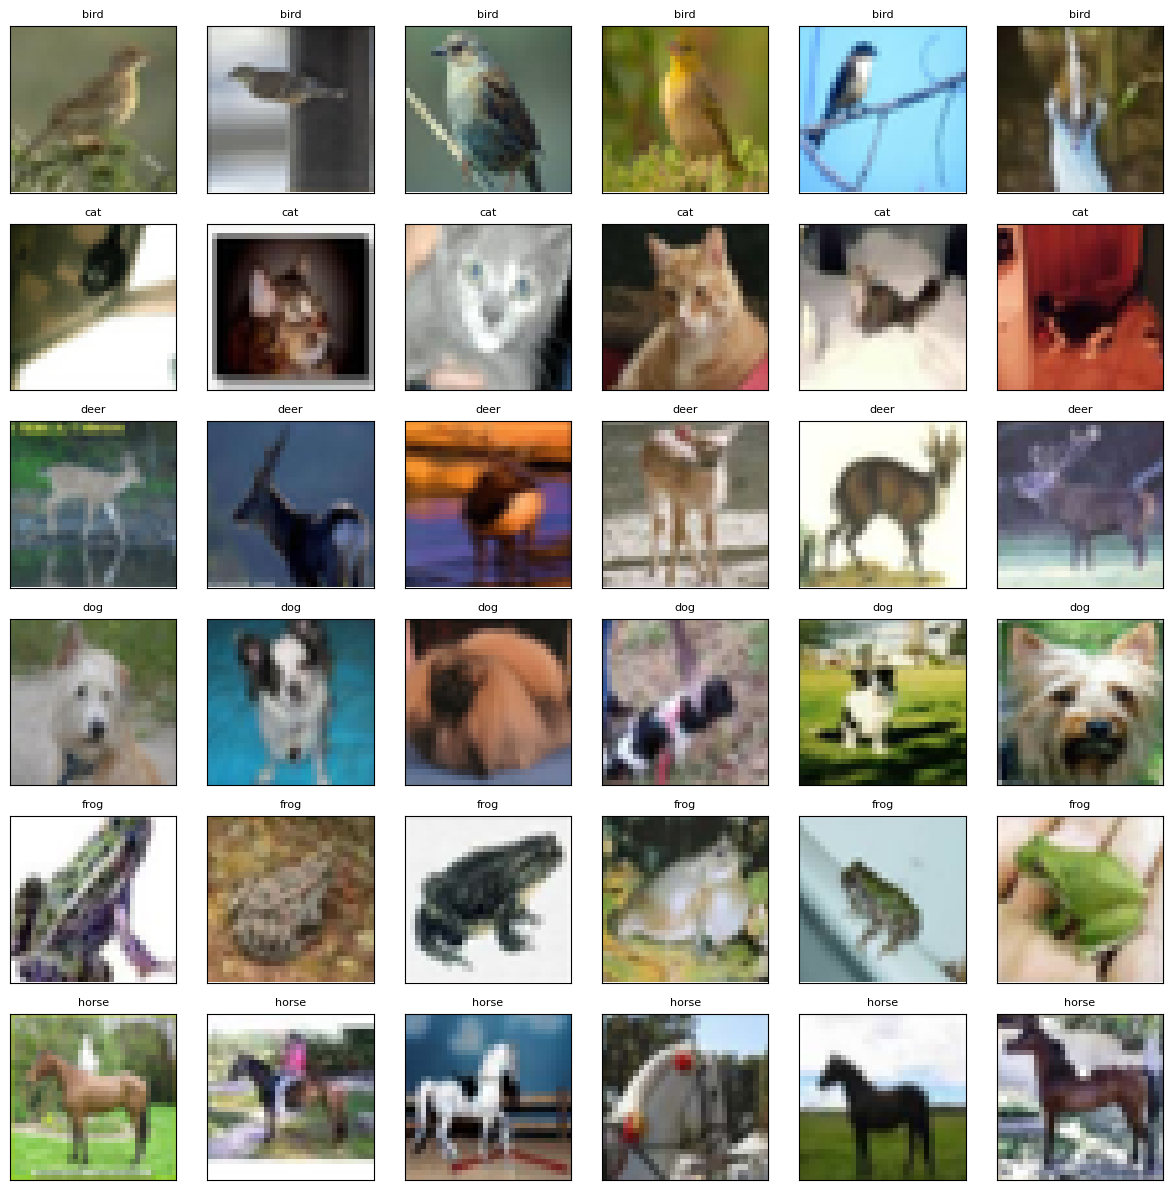

In [13]:
show_random_examples_per_class((x10_train, y10_train), num_per_class=6, classes=classes_dictionary)

In [14]:
classes_dictionary = get_selected_classes_dictionary(cifar10_labels, selected=['truck', 'automobile'])

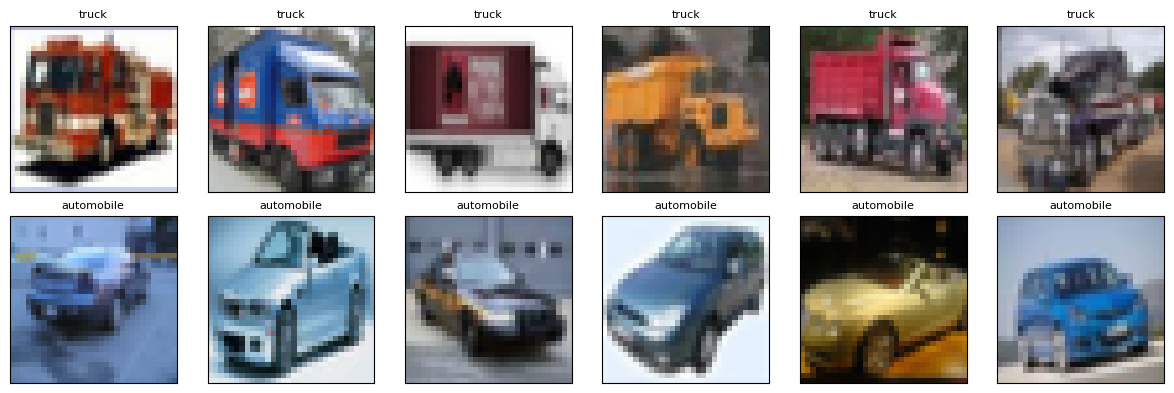

In [15]:
show_random_examples_per_class((x10_train, y10_train), num_per_class=6, classes=classes_dictionary)

#### CIFAR100

Di seguito, viene riportata la lista delle 100 etichette presenti nel dataset, presa direttamente dal sito ufficiale del dataset.

In [16]:
cifar100_labels = [
                            'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
                            'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
                            'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
                            'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
                            'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
                            'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
                            'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
                            'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
                            'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
                            'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea',
                            'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
                            'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
                            'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
                            'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
                            'worm'
    ]

In [17]:
(x100_train, y100_train), (x100_test, y100_test) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

In [18]:
x100_train.shape

(50000, 32, 32, 3)

In [19]:
np.unique(y100_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 5

In [20]:
np.unique(y100_test, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 1

Anche nel caso di CIFAR100 questo caso le categorie sono  tutte perfettamente bilanciate, sia tra di loro che nella suddivisione train test. Questa volta il dominio è più ampio poiché include entità che non rientrano né nella categoria di veicoli, né in quella degli animali. Dall'altra parte, sono presenti molte più categorie di animali e di veicoli. In questo caso, il numero di immagini di allenamento e di test si riduce notevolmente per ogni categoria (500).

In [21]:
classes_dictionary = get_selected_classes_dictionary(cifar100_labels, selected=['streetcar', 'pickup_truck'])

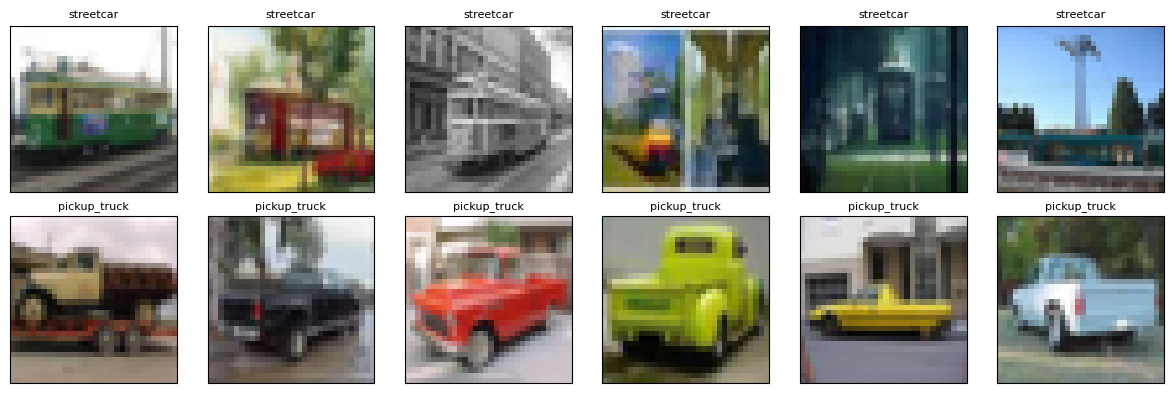

In [22]:
show_random_examples_per_class((x100_train, y100_train), num_per_class=6, classes=classes_dictionary)

**CIFAR-10** offre un setting più semplice da gestire grazie alla presenza di sole dieci classi; ciò riduce la complessità del modello e consente iterazioni più rapide. Le classi presenti sono ben rappresentate con migliaia di esempi ciascuna, garantendo variabilità interna e favorendo un apprendimento più veloce, poco costosto in termini computazionali, più stabile e robusto. Tuttavia, alcune delle classi non sono pertinenti al dominio urbano (come aerei, navi o rane) e mancano categorie utili come i veicoli a due ruote.

**CIFAR-100**, al contrario, mette a disposizione una varietà semantica molto maggiore, inclusiva di classi che potrebbero essere più vicine al dominio obiettivo e offre la possibilità di esplorare classificazioni più granulari. Tuttavia, l’aumento del numero di classi introduce maggior complessità nel modello, una maggiore probabilità di confusione tra classi affini con conseguente aumento degli errori in più. Inoltre, ciascuna classe “fine” in CIFAR-100 ha un numero significativamente inferiore di esempi rispetto a CIFAR10, il che può rendere più difficile per la rete apprendere in modo efficace ciascuna classe.

Per questo progetto viene scelto di tentare di raggiungere un'alta copertura di classi di possibili ostacoli nel contesto urbano. Questo comporta quindi la scelta del dataset **CIFAR100** come base per allenare il nostro modello. Adesso saranno però aggiunte immagini di CIFAR10 riguardanti categorie utili al task ma assenti in CIFAR100.

## 4. Selezione delle classi

Si propone la seguente selezione delle classi da CIFAR10 e CIFAR100.

| **Etichette Originali** | **Dataset originale**      | **Macro-classe**                         |
| ---------------- | -------------------------- | ----------------------------------------------- |
| automobile       | CIFAR10                    | vehicle                                         |
| truck            | CIFAR10                    | vehicle                                         |
| pickup_truck     | CIFAR100                   | vehicle                                         |
| motorcycle       | CIFAR100                   | vehicle                                         |
| bicycle          | CIFAR100                   | vehicle                                         |
| bus              | CIFAR100                   | vehicle                                         |
| streetcar        | CIFAR100                   | vehicle                                         |
| train            | CIFAR100                   | vehicle                                         |
| dog              | CIFAR10                    | animal                                          |
| cat              | CIFAR10                    | animal                                          |
| bird             | CIFAR10                    | animal                                          |
| horse            | CIFAR10                    | animal                                          |
| mouse            | CIFAR100                   | animal                                          |
| rabbit           | CIFAR100                   | animal                                          |
| raccoon           | CIFAR100                   | animal                                          |
| fox              | CIFAR100                   | animal                                          |
| wolf             | CIFAR100                   | animal                                          |
| skunk            | CIFAR100                   |animal                                          |
| squirrel         | CIFAR100                   |animal                                          |

I veicoli inclusi rappresentano veicoli effettivamente presenti nelle città, anche i treni sono inclusi per un sistema pensato per aree limitrofe alle linee ferroviarie o passaggi a livello.

L’inclusione delle categorie animali è motivata dal fatto che rappresentano specie realisticamente presenti nei contesti urbani e soprattutto periurbani, dove il rischio di attraversamenti improvvisi è concreto e rilevante per la sicurezza stradale.
- **Cani e gatti** sono tra gli animali domestici più comuni nelle aree abitate.
- **Uccelli, scoiattoli, topi e conigli** popolano regolarmente parchi, giardini e zone verdi interne alle città.
- **Cervi e cavalli**, pur essendo meno tipici dell’ambiente urbano, sono frequentemente presenti nelle immediate periferie, in aree rurali o boschive adiacenti ai centri abitati, dove costituiscono una causa significativa di incidenti.
- **Volpi, procioni, puzzole e lupi** sono specie selvatiche che negli ultimi anni hanno ampliato la loro presenza nelle zone periurbane, attirate dalla disponibilità di cibo e habitat favorevoli, e il loro monitoraggio è cruciale per prevenire collisioni, garantire la sicurezza dei cittadini e ridurre l’impatto sul traffico.

Nel processo di selezione delle classi per il modello di riconoscimento di ostacoli in ambiente urbano, sono stati applicati criteri di pertinenza semantica e realismo applicativo. Le seguenti tipologie di classi sono state escluse per le ragioni indicate:

- **Classi non riconducibili al dominio urbano** come *airplane*, *ship*, *frog*, *dinosaur*, *whale*, *forest*, *mountain* e simili, tipiche di CIFAR-10 e CIFAR-100, rappresentano oggetti, animali o altri tipi di veicolo che non costituiscono potenziali ostacoli all’interno dell’ambiente stradale urbano. L’inclusione di tali categorie aumenterebbe la complessità del task senza apportare valore pratico e rischierebbe di generare false attivazioni o ridurre la capacità discriminativa del modello.

- **Classi appartenenti ad animali esotici o rari in ambiente urbano** come animali esotici, selvatici o difficilmente presenti in città (es. *tiger*, *lion*, *elephant*, *crocodile*, *porcupine*) sono escluse, in quanto la probabilità di incontrarli come ostacoli su strada in contesto urbano è trascurabile.

Viene effettuato il seguente procedimento:

1) Definizione della mappa etichetta_origine → macro-classe

In [23]:
label_to_macro = {
    "automobile": "vehicle",
    "pickup_truck": "vehicle",
    "motorcycle": "vehicle",
    "bicycle": "vehicle",
    "bus": "vehicle",
    "streetcar": "vehicle",
    "truck": "vehicle",
    "train": "vehicle",
    "dog": "animal",
    "cat": "animal",
    "bird": "animal",
    "horse": "animal",
    "mouse": "animal",
    "rabbit": "animal",
    "raccoon": "animal",
    "fox": "animal",
    "wolf": "animal",
    "skunk": "animal",
    "squirrel": "animal"
}

2) Funzione che dato un dataset array di etichette numeriche restituisce le macro-classi corrispondenti

In [24]:
def map_labels_to_macro(label_array, label_names) -> np.ndarray:
    """
    label_array: array NumPy di forma (N, 1) o (N,) contenente etichette numeriche.
    label_names: lista che mappa gli indici numerici alle etichette testuali originali.
    Restituisce: Un array NumPy contenente le macro-classi corrispondenti a ciascuna etichetta.
    """
    macros = []
    for lbl in label_array.ravel():
        orig = label_names[lbl]
        macro = label_to_macro.get(orig, None)
        if macro is None:
            macro = "ALTRO"
        macros.append(macro)
    return np.array(macros)

3) Caricamento dataset e applicazione della mappatura

In [25]:
# CIFAR-10
y10_train_macro = map_labels_to_macro(y10_train, cifar10_labels)
y10_test_macro  = map_labels_to_macro(y10_test, cifar10_labels)

print("CIFAR10 – esempi:", y10_train[:5].ravel(), "→ macro:", y10_train_macro[:5])

# CIFAR-100
y100_train_macro = map_labels_to_macro(y100_train, cifar100_labels)
y100_test_macro  = map_labels_to_macro(y100_test, cifar100_labels)

print("CIFAR100 – esempi:", y100_train[:5].ravel(), "→ macro:", y100_train_macro[:5])

CIFAR10 – esempi: [6 9 9 4 1] → macro: ['ALTRO' 'vehicle' 'vehicle' 'ALTRO' 'vehicle']
CIFAR100 – esempi: [19 29  0 11  1] → macro: ['ALTRO' 'ALTRO' 'ALTRO' 'ALTRO' 'ALTRO']


4) Conversione della la macro-classe in codifica numerica.

In [26]:
# Lista delle macro-classi
unique_macros = sorted(set(label_to_macro.values()))
unique_macros.append("ALTRO")
macro_to_index = {m:i for i,m in enumerate(unique_macros)}

In [27]:
# Mappatura dei valori stringa a interi
y10_train_macro_idx = np.array([macro_to_index[m] for m in y10_train_macro])
y10_test_macro_idx  = np.array([macro_to_index[m] for m in y10_test_macro])
y100_train_macro_idx = np.array([macro_to_index[m] for m in y100_train_macro])
y100_test_macro_idx  = np.array([macro_to_index[m] for m in y100_test_macro])

print("Macro-classe lista:", unique_macros)
print("Macro indice mapping:", macro_to_index)

Macro-classe lista: ['animal', 'vehicle', 'ALTRO']
Macro indice mapping: {'animal': 0, 'vehicle': 1, 'ALTRO': 2}


Di seguito vengono esclusi gli elementi dei dataset che non ricadono nelle due categorie 'animal' e 'vehicle'.

In [28]:
x10_train_down = x10_train[y10_train_macro_idx != 2]
y10_train_down = y10_train_macro_idx[y10_train_macro_idx != 2]

In [29]:
x10_test_down = x10_test[y10_test_macro_idx != 2]
y10_test_down = y10_test_macro_idx[y10_test_macro_idx != 2]

In [30]:
x100_train_down = x100_train[y100_train_macro_idx != 2]
y100_train_down =  y100_train_macro_idx[y100_train_macro_idx != 2]

In [31]:
x100_test_down = x100_test[y100_test_macro_idx != 2]
y100_test_down = y100_test_macro_idx[y100_test_macro_idx != 2]

In [32]:
X_train = np.concatenate((x10_train_down, x100_train_down))
y_train = np.concatenate((y10_train_down, y100_train_down))

In [33]:
X_test = np.concatenate((x10_test_down, x100_test_down))
y_test = np.concatenate((y10_test_down, y100_test_down))

In [34]:
unique_macros.remove('ALTRO')

In [35]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([23500, 13000]))

Gli esperimenti prevedono l’addestramento di reti neurali convoluzionali, per le quali è fondamentale disporre sia di un validation set sia di un test set distinti. Il validation set viene utilizzato durante l’allenamento per monitorare le prestazioni del modello e permettere alle callback di regolare dinamicamente parametri come il learning rate o l’early stopping. Il test set, invece, deve rimanere separato e mai coinvolto nell’addestramento, così da fornire una misura imparziale della capacità di generalizzazione del modello. Poiché il dataset di training è sufficientemente ampio, una sua porzione (circa il 10%) viene estratta e utilizzata come validation set, mantenendo intatte le dimensioni del test per la valutazione finale.

In [36]:
RANDOM_SEED = 42

In [37]:
X_train_reduced, X_val, y_train_reduced, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=RANDOM_SEED, stratify=y_train
)

## 5. Analisi del nuovo dataset di allenamento

Questa sezione è dedicata all'esplorazione del nuovo dataset ottenuto mettendo insieme immagini di CIFAR10 e CIFAR100. Di seguito vengono memorizzate le etichette originali delle immagini del dataset per poter fare successivamente analisi sulle classi originali.

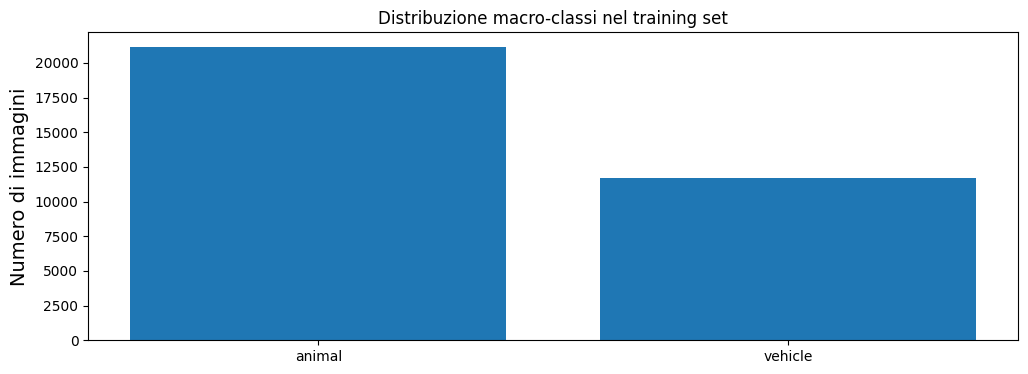

In [38]:
labels, counts = np.unique(np.vectorize(lambda i: unique_macros[i])(y_train_reduced), return_counts=True)

plt.figure(figsize=(12,4))
plt.bar(labels, counts)
plt.title("Distribuzione macro-classi nel training set")
plt.ylabel("Numero di immagini", size=14)

plt.show()

L'istogramma mostra un evidente sbilanciamento sulla classe 'animal' poiché in essa confluiscono quattro classi di CIFAR10 su sei, le quali hanno 5000 immagini per ciascuna. Sarà opportuno vedere se tale sbilanciamento comporta complicazioni e se la varietà interna delle due macro classi le rende difficilmente separabili. Di sotto è possibile notare come lo sbilanciamento permanga anche nel dataset di validazione e in quello di test con le stesse proporzioni

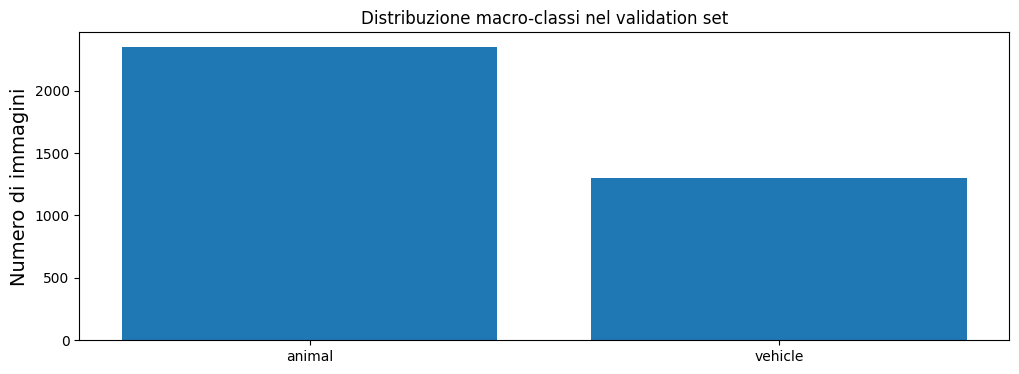

In [39]:
labels, counts = np.unique(np.vectorize(lambda i: unique_macros[i])(y_val), return_counts=True)

plt.figure(figsize=(12,4))
plt.bar(labels, counts)
plt.title("Distribuzione macro-classi nel validation set")
plt.ylabel("Numero di immagini", size=14)

plt.show()

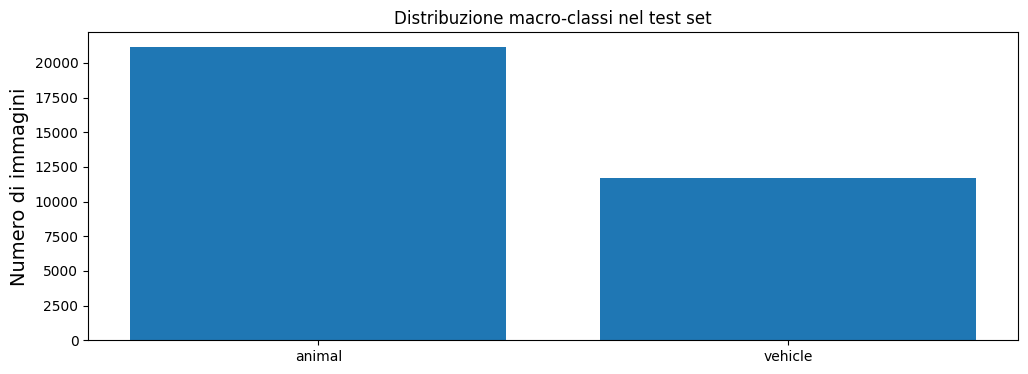

In [40]:
labels, counts = np.unique(np.vectorize(lambda i: unique_macros[i])(y_train_reduced), return_counts=True)

plt.figure(figsize=(12,4))
plt.bar(labels, counts)
plt.title("Distribuzione macro-classi nel test set")
plt.ylabel("Numero di immagini", size=14)

plt.show()

## 6. Sperimentazione di una CNN

Viene fatta la scelta di allenare da zero una CNN piccola invece di utilizzare architetture molto grandi pre-addestrate su ImageNet (come ResNet-50 o MobileNet) per un task di classificazione binaria su un dataset in stile CIFAR composto da circa 36.500 immagini. Questa decisione è motivata da una serie di considerazioni:

> - **Dimensione ridotta del dataset rispetto alla capacità del modello**.
Modelli di grande scala possiedono un numero elevatissimo di parametri. Su un dataset relativamente piccolo, come 36k immagini a bassa risoluzione, questa capacità eccessiva può portare con facilità a overfitting: il modello tende a memorizzare i pochi pattern presenti invece di imparare rappresentazioni realmente generali.

> - **Disallineamento tra le caratteristiche di ImageNet e quelle del dataset CIFAR-like**.
Le reti pre-addestrate su ImageNet imparano pattern tipici di immagini ad alta risoluzione e di oggetti molto diversi rispetto a quelli presenti nel dominio CIFAR. Questo mismatch può ridurre l’efficacia del transfer learning e richiedere comunque una fase di adattamento non banale.

> - **La complessità del modello non è necessaria per il task**.
Una classificazione binaria su immagini piccole non richiede la potenza rappresentativa di architetture profonde. Un modello più piccolo può catturare adeguatamente i pattern rilevanti senza la necessità di un apparato così complesso.

> - **Maggiore facilità di generalizzazione costruendo un modello più compatto**.
Un modello con meno parametri è “costretto” a imparare pattern più semplici e generali. Questo tende a migliorare la generalizzazione, specialmente quando il dominio è più ristretto e il compito più semplice rispetto a ImageNet.

> - **Transfer learning non sempre porta vantaggi netti**.
Sebbene il transfer learning sia potente perché parte da pesi che incorporano concetti generali, non è garantito che questi concetti siano utili nel caso di immagini molto diverse da quelle su cui il modello è stato pre-addestrato. In alcuni casi, il modello può addirittura essere “bloccato” da rappresentazioni non ottimali.

Il tutto porta a concludere che:

> - **Il fine-tuning completo può essere rischioso**. Aggiornare tutti i parametri di un modello pre-addestrato ampio su un dataset piccolo aumenta fortemente il rischio di overfitting.

> - **Il fine-tuning parziale sarebbe poco efficace**. Aggiornare solo gli ultimi layer, invece, può risultare insufficiente per catturare i pattern specifici del nuovo dominio, dato il divario tra ImageNet e CIFAR.

### 6.1 Costruzione della rete

Questa sezione è dedicata alla costruzione della rete neurale convoluzionale che sarà addestrata per riconoscere animali e veicoli.

In [41]:
def build_baseline_model() -> Sequential:
    """
    Crea e restituisce un modello di base di tipo Keras Sequential.

    Il modello prodotto è una rete neurale convoluzionale progettata per
    classificazione binaria su immagini di dimensione 32×32×3. Include
    blocchi convoluzionali, normalizzazione e livelli fully connected,
    con dropout per ridurre l’overfitting.

    Restituisce
    ----------
    tf.keras.Sequential
        Un modello Sequenziale Keras pronto per essere compilato e addestrato.
    """

    w_init = tf.keras.initializers.RandomNormal(stddev=0.01)

    model = Sequential()

    # Input Layer
    model.add(InputLayer(shape=(32, 32, 3)))

    # Conv Block 1
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Conv Block 2
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Conv Block 3
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())

    # Classifier
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

Il modello di base costruito nella funzione implementata sopra è chiaramente a VGG, anche se in versione molto più piccola e con diverse regolarizzazioni. È suddiviso nei seguenti blocchi:

> - **Input Layer**, che specifica esplicitamente la forma delle immagini, fissata a 32×32×3, la risoluzione di CIFAR.

> - **Conv Block 1**, primo blocco convoluzionale dedicato all’estrazione delle feature più semplici. La convoluzione con 32 filtri 3×3 consente di catturare bordi, gradienti e micro-pattern basilari, che costituiscono le fondamenta delle rappresentazioni che la rete costruirà in seguito. La Batch Normalization stabilizza la distribuzione delle attivazioni interne e rende il training più robusto, mentre il MaxPooling dimezza la risoluzione e concentra l’attenzione del modello sulle caratteristiche più salienti della scena. Infine, il Dropout introduce una forma di regolarizzazione che riduce la tendenza della rete a memorizzare le immagini del dataset, particolarmente utile quando si lavora con dataset di dimensioni moderate.

> - **Conv Block 2**, secondo blocco convoluzionale che rappresenta un livello di astrazione leggermente più complesso. L’aumento a 64 filtri permette al modello di combinare le feature individuate nel primo blocco in strutture più articolate, come forme parziali o texture caratteristiche. Anche qui la Batch Normalization contribuisce alla stabilità numerica e alla regolarizzazione, mentre il MaxPooling riduce ulteriormente la dimensione spaziale, rendendo più efficiente la parte finale della rete. Il Dropout, qui applicato nuovamente, serve a bilanciare la crescita della capacità del modello, evitando che il secondo blocco diventi troppo dominante e porti a overfitting.

> - **Conv Block 3**.Il terzo blocco convoluzionale ha il compito di individuare pattern più complessi e discriminativi attraverso 128 filtri, che rappresentano il livello di astrazione più elevato della rete. Questi filtri catturano combinazioni di feature provenienti dagli strati precedenti e tendono a isolare elementi che possono essere particolarmente utili per distinguere tra le due classi. La presenza della Batch Normalization in questo punto è fondamentale perché mantiene stabili le attivazioni nonostante l’aumento del numero di filtri. In questo blocco non viene applicato pooling, poiché è preferibile preservare più informazione possibile prima della fase di classificazione.

> - **Classifier**. La parte finale del modello è dedicata alla classificazione. Il livello di Flatten trasforma il volume tridimensionale in un vettore, consentendo il passaggio agli strati densi. Il livello denso da 128 neuroni rappresenta la parte più esplicitamente non lineare della rete e permette di combinare in modo flessibile tutte le feature apprese durante la fase convoluzionale. Il Dropout con un tasso più elevato in questo punto svolge un ruolo particolarmente importante, perché gli strati densi sono i più inclini a memorizzare i dati di training. L’ultimo livello, composto da un singolo neurone con attivazione sigmoid, restituisce una probabilità che l’immagine appartenga alla classe positiva e completa il processo di classificazione binaria in modo semplice e diretto.

N.B. Nella rete, il padding delle convoluzioni è sempre impostato a `same` cosa che comporta che, per ogni convoluzione, la dimensione spaziale dell’output rimane invariata rispetto all’input. Questo permette ai filtri di operare su ogni pixel dell'immagine, compresi i bordi, senza che l’applicazione della convoluzione riduca progressivamente la risoluzione. In una rete che elabora immagini 32×32, mantenere costanti le dimensioni durante la fase convoluzionale è particolarmente importante perché evita che la rappresentazione diventi troppo piccola troppo presto, preservando il dettaglio spaziale necessario per apprendere pattern significativi.
Il ridimensionamento della mappa delle attivazioni è delegato esclusivamente ai livelli di pooling, che in questa architettura hanno il compito esplicito di ridurre la risoluzione in modo controllato.

In [64]:
clear_session()

In [42]:
model = build_baseline_model()

In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,142,977 (4.36 MB)

 Trainable params: 1,142,529 (4.36 MB)

 Non-trainable params: 448 (1.75 KB)

### 7.2 Allenamento

Questa sezione è dedicata all'allenamento del modello.
Per prima cosa, vengono definite le callback che saranno usate per monitorare la e intervenire sull'allenamento in base al suo andamento.

La callback **EarlyStopping** interrompe l’addestramento quando la metrica monitorata smette di migliorare. In questo caso si è scelto di osservare la val_accuracy, cioè la capacità del modello di generalizzare sui dati di validazione. Il parametro `patience=15` permette al processo di proseguire ancora per diverse epoche nonostante piccole oscillazioni, evitando interruzioni premature. Il valore `min_delta=0.001` impone che per essere considerato un vero miglioramento l’aumento dell’accuratezza debba essere almeno dello `0.1%`. La scelta di `restore_best_weights=True` garantisce che al termine dell’addestramento il modello recuperi automaticamente i pesi migliori ottenuti durante l’intero processo. Questa configurazione mira a evitare overfitting e per fermare l’addestramento nel caso non si verifichino miglioramenti significativi a partire da una determinata epoca.

In [44]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=15,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

La callback **ReduceLROnPlateau** riduce automaticamente il learning rate quando la metrica monitorata non migliora più. Qui si è scelto di seguire la `val_loss`, un indicatore molto sensibile alla qualità dell’addestramento e più reattivo dell’accuratezza a piccoli cambiamenti. Quando la perdita di validazione non diminuisce per almeno 5 epoche (`patience=5`), il learning rate viene dimezzato (`factor=0.5`) per permettere al modello di effettuare passi più piccoli e raffinati nella fase finale del training. Il limite inferiore `min_lr=1e-6` evita che il learning rate diventi troppo piccolo, rallentando inutilmente il processo. Questa scelta aiuta il modello a stabilizzarsi e a convergere con precisione senza oscillazioni nella loss.

In [45]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1,
    mode='min'
)

La callback ModelCheckpoint salva su file il modello che ottiene il punteggio migliore sulla metrica monitorata, in questo caso ancora val_accuracy. Il parametro `save_best_only=True` assicura che venga salvata solo la versione ottimale, evitando di memorizzare molteplici modelli intermedi inutili. L’uso della `val_accuracy` come riferimento è coerente con l’obiettivo di ottenere una rete che generalizzi bene, indipendentemente dalla perdita su training. Questa configurazione è stata pensata per garantire che, anche se l’addestramento dovesse degenerare nelle epoche successive, il modello migliore venga preservato.

In [46]:
checkpoint = ModelCheckpoint(
    filepath=f'{base_path}/small_CNN.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

La callback **CSVLogger** salva la storia di addestramento su file csv.

In [48]:
csv_logger = CSVLogger(f'{base_path}/training_log.csv', append=False)

La seguente istruzione definisce il modo in cui il modello verrà addestrato, specificando l'ottimizzatore, la funzione di perdita e le metriche di valutazione. In questo caso viene scelta la seguente configurazione:

> - La scelta dell’ottimizzatore **Adam** è motivata dalla sua capacità di adattare dinamicamente il learning rate dei singoli pesi durante l’addestramento, combinando i vantaggi di AdaGrad e RMSProp. È particolarmente adatto a problemi di visione artificiale e funziona bene in molti scenari senza richiedere un’accurata ottimizzazione manuale dei parametri. Ciò permette al modello di convergere rapidamente e in maniera stabile, caratteristiche utili soprattutto in architetture CNN come quella utilizzata.

> - La funzione di perdita **binary crossentropy** è la scelta appropriata per un problema di classificazione binaria, poiché misura quanto la distribuzione delle predizioni si discosta dai valori reali (0 o 1). Questa perdita è ideale quando l’output del modello è una singola unità con attivazione sigmoid, come avviene in questo caso, e consente di addestrare il modello in modo da massimizzare la probabilità assegnata alla classe corretta.

> - Infine, la metrica **accuracy** fornisce una misura intuitiva e immediata della qualità delle predizioni: indica la percentuale di esempi classificati correttamente e rappresenta un indicatore chiaro durante il training, utile per monitorare l’andamento dell’apprendimento. Nel caso di classificazione binaria  è una metrica adeguata e facilmente interpretabile.

In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
history = model.fit(X_train_reduced, y_train_reduced, epochs=40, validation_data=(X_val, y_val), callbacks=[early_stop, checkpoint, reduce_lr, csv_logger], verbose=1)

Epoch 1/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step - accuracy: 0.8945 - loss: 0.2800 - val_accuracy: 0.9395 - val_loss: 0.1632 - learning_rate: 0.0010
Epoch 2/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 45s 34ms/step - accuracy: 0.9259 - loss: 0.1952 - val_accuracy: 0.9216 - val_loss: 0.1957 - learning_rate: 0.0010
Epoch 3/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.9399 - loss: 0.1657 - val_accuracy: 0.9477 - val_loss: 0.1478 - learning_rate: 0.0010
Epoch 4/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 85s 47ms/step - accuracy: 0.9483 - loss: 0.1458 - val_accuracy: 0.9542 - val_loss: 0.1295 - learning_rate: 0.0010
Epoch 5/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 81s 46ms/step - accuracy: 0.9506 - loss: 0.1327 - val_accuracy: 0.9504 - val_loss: 0.1478 - learning_rate: 0.0010
Epoch 6/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.9563 - loss: 0.1207 - val_accuracy: 0.9047 - val_loss: 0.3140 - learning_rate: 0.0010
Epoch 7/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step - accura

### 7.3 Risultati

Questa sezione è dedicata alla visualizzazione e discussione dei risultati ottenuti dal modello allenato.

In [ ]:
model = tf.keras.models.load_model('small_CNN.keras')

In [51]:
def plot_history(history):
    """
    Visualizza le curve di apprendimento dei modelli di machine learning

    Parametri
    ---------
    history : dict o History.history
        Dizionario contenente le liste dei valori registrati durante il training
        per le metriche 'accuracy', 'val_accuracy', 'loss' e 'val_loss'.

    Descrizione
    -----------
    La funzione crea due grafici affiancati:
    - A sinistra l'andamento di accuracy e val_accuracy, utile per valutare
      la capacità del modello di apprendere e generalizzare.
    - A destra l'andamento di loss di training e di validazione, utilizzato per individuare
      eventuali fenomeni di overfitting o instabilità durante il training.

    I limiti sugli assi sono impostati per rendere più leggibile il confronto
    tra le curve e facilitare l'interpretazione visiva dei risultati.
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='accuracy')
    plt.plot(history['val_accuracy'], label='val_accuracy')
    plt.ylim(0.6, 1)

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.ylim(0, 0.9)

    plt.legend()

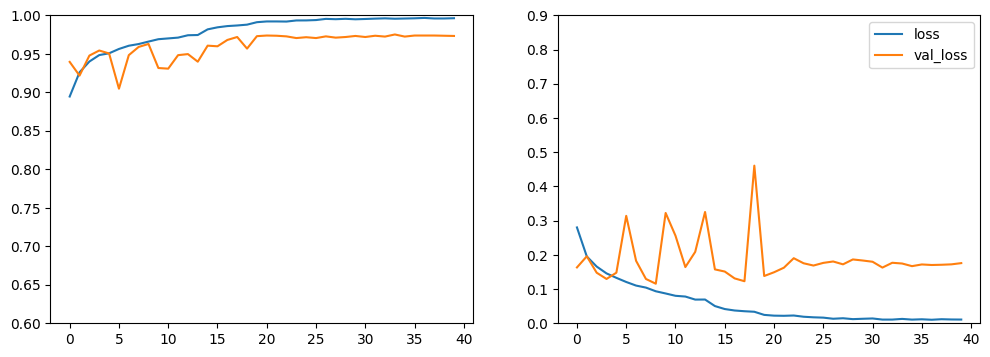

In [52]:
plot_history(history.history)

La learning curve mostra che la rete impara molto rapidamente e raggiunge in poche epoche un’accuratezza altissima, con il training che arriva quasi al 99% e la validazione che si stabilizza attorno al 97–98%. Anche la loss riflette questa dinamica: quella di training scende fino quasi a zero, mentre quella di validazione presenta qualche oscillazione ma rimane complessivamente bassa. Non emerge un overfitting significativo, perché la validazione non peggiora e rimane vicina al training, con un divario molto piccolo. Il plateau finale indica che la rete ha già imparato quasi tutto ciò che poteva dal dataset e che nelle ultime epoche non ci sono miglioramenti significativi.

In [53]:
y_pred_train = model.predict(X_train)

1141/1141 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step


In [54]:
y_pred_train = np.round(y_pred_train)

In [55]:
print(classification_report(y_train, y_pred_train, target_names=unique_macros))

              precision    recall  f1-score   support

      animal       1.00      1.00      1.00     23500
     vehicle       1.00      1.00      1.00     13000

    accuracy                           1.00     36500
   macro avg       1.00      1.00      1.00     36500
weighted avg       1.00      1.00      1.00     36500



In [56]:
y_pred_test_proba = model.predict(X_test)

229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


In [57]:
y_pred_test = np.round(y_pred_test_proba)

In [58]:
print(classification_report(y_test, y_pred_test, target_names=unique_macros))

              precision    recall  f1-score   support

      animal       0.97      0.98      0.98      4700
     vehicle       0.97      0.95      0.96      2600

    accuracy                           0.97      7300
   macro avg       0.97      0.97      0.97      7300
weighted avg       0.97      0.97      0.97      7300



Il confronto tra training e test classification report mostra un modello che generalizza bene e mantiene prestazioni elevate senza cadere in overfitting evidente.
Nel training set il modello raggiunge valori molto alti su entrambe le classi, con precisione e recall vicino al 100%. Nel test queste metriche calano leggermente, ma rimangono comunque molto robuste: 0.98 per la classe animal e 0.96 per vehicle. La differenza tra training e test è contenuta, segno che la rete ha appreso pattern reali e non si è limitata a memorizzare i dati.
Si nota inoltre che la classe vehicle, che dispone di meno esempi, mostra valori leggermente inferiori rispetto alla classe maggioritaria, ma rimane comunque ben gestita. Il recall di vehicle sul test (0.95) indica che il modello riesce a individuare correttamente la maggior parte degli esempi minoritari, e il f1-score elevato conferma un equilibrio stabile tra precisione e sensibilità.

Di seguito è presentata una funzione che visualizza la matrice di confusione come una heatmap utilizzando la palette `YlGnBu`, in cui il giallo rappresenta valori più bassi e il blu valori più alti. La funzione è progettata affinché la scala cromatica non si basi sui valori assoluti, ma sulle percentuali rispetto al totale di ciascuna classe. In questo modo le gradazioni rimangono coerenti anche in presenza di un forte sbilanciamento tra le categorie.


In [59]:
def plot_confusion_matrix_colorbar_pct(y_test, y_pred, labels=[]):
    """
    Genera una matrice di confusione normalizzata con annotazioni dei valori
    assoluti e una colorbar espressa in percentuale.

    Parametri
    ---------
    y_test : array-like
        Etichette reali delle classi.

    y_pred : array-like
        Etichette predette dal modello.

    labels : list, opzionale
        Lista dei nomi delle classi nell’ordine corrispondente agli assi
        della matrice di confusione. Se fornita, verrà usata come etichette
        sull’asse x, mentre sull’asse y compariranno i nomi delle classi
        accompagnati dalla loro cardinalità (numero di campioni reali per classe).

    Descrizione
    -----------
    - Calcola la matrice di confusione e la normalizza dividendo ogni riga per
      il numero totale di campioni della classe corrispondente.
    - Mostra i valori assoluti all’interno delle celle tramite annotazioni.
    - Visualizza la matrice normalizzata mediante una heatmap.
    - La colorbar rappresenta le proporzioni normalizzate in formato percentuale.
    - Le etichette delle righe includono anche la cardinalità della classe,
      utile per evidenziare eventuali squilibri tra le classi.
    - Le etichette degli assi vengono ruotate per migliorarne la leggibilità.

    Output
    ------
    Visualizza una heatmap che mostra:
    - I conteggi assoluti in ogni cella.
    - L’intensità del colore basata sulle proporzioni normalizzate.
    - Una colorbar con valori in percentuale (0–100%).
    """

    cf = confusion_matrix(y_test, y_pred)
    row_sums = cf.sum(axis=1, keepdims=True)
    cf_norm = cf.astype('float') / row_sums

    cardinalities = cf.sum(axis=1).tolist()

    labels_with_cardinality = [f"{label} ({cardinality})" for label, cardinality in zip(labels, cardinalities)]

    fig, ax = plt.subplots(figsize=(6, 4), dpi=70)
    heat = sns.heatmap(
        cf_norm,
        annot=cf,
        fmt='d',
        xticklabels=labels,
        yticklabels=labels_with_cardinality,
        cmap="YlGnBu",
        cbar_kws={
            'format': PercentFormatter(1.0),
        }
    )

    cbar = heat.collections[0].colorbar

    ax.tick_params(axis='y', labelrotation=0)
    ax.tick_params(axis='x', labelrotation=45)
    plt.title('Confusion Matrix (colorbar in %)')

    plt.show()

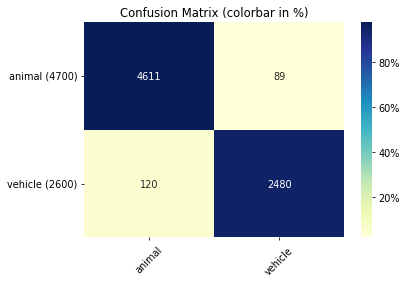

In [60]:
plot_confusion_matrix_colorbar_pct(y_test, y_pred_test, labels=unique_macros)

La matrice di confusione mostra che il modello riconosce entrambe le classi con un’elevata accuratezza e senza segni di un vero bias verso quella più rappresentata. Per la classe “animale”, 4611 esempi su 4700 vengono classificati correttamente, mentre solo 89 vengono scambiati per veicoli.

Per la classe "vehcile", 2480 esempi su 2600 risultano corretti, con 120 errori in cui vengono interpretati come animali. L’accuratezza per entrambe le classi supera il 95%, con un f1-score di 0.96 per i veicoli e 0.98 per gli animali. La leggera differenza nelle prestazioni indica che i veicoli risultano un po’ più difficili da distinguere, ma non suggerisce un reale sbilanciamento o una preferenza sistematica del modello verso la classe maggioritaria.

Per completezza, viene quindi scelto di visualizzare la ROC curve,perché mostra come variano la sensibilità e il tasso di falsi positivi al variare della soglia, poiché la confusion matrix mostra il comportamento del modello solo con soglia 0,5.

In [61]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba)
roc_auc = auc(fpr, tpr)

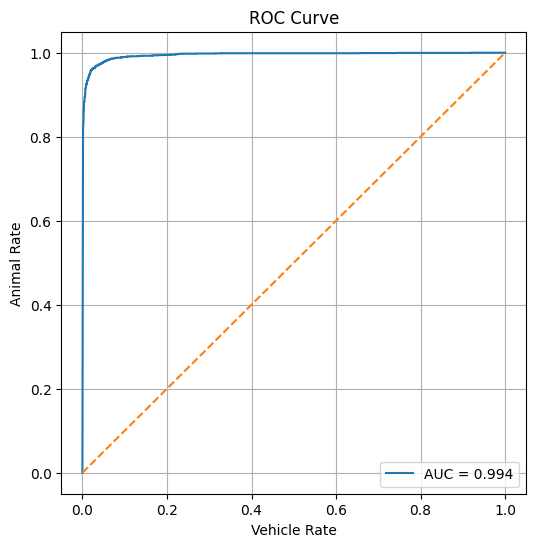

In [62]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')      # linea casuale
plt.xlabel('Vehicle Rate')
plt.ylabel('Animal Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

La tua ROC curve mostra che il modello distingue animali e veicoli in modo estremamente efficace. La curva si avvicina molto al bordo superiore sinistro, il che significa che il tasso di falsi positivi è molto basso mentre quello di veri positivi è molto alto. Il valore AUC pari a 0.994 indica una capacità discriminativa quasi perfetta. Questo suggerisce che il modello riconosce quasi sempre correttamente i veicoli senza confonderli con animali e che l’eventuale sbilanciamento del dataset non ha avuto un impatto negativo misurabile sulla capacità del modello di separare le due classi.

### 7. Pesatura della funzione di perdita

Questa sezione è dedicata alla ripetizione dell'esperimento precedente con la pesatura della funzione di perdita, che permette di simulare una situazione in cui le due classi hanno la stessa importanza statistica, anche se nel dataset reale non è così. In questo modo, è possibile verificare direttamente quanto lo sbilanciamento influenzi davvero il comportamento del modello.

In [74]:
clear_session()

In [75]:
model = build_baseline_model()

Di seguito, la funzione `class_weight.compute_class_weight` esegue il calcolo dei pesi applicando la seguente formula.

$$ \text{weight}_i = \frac{N_{\text{totale}}}{2 \cdot N_i} $$

In [76]:
weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(y_train),
    y = y_train
)

In [77]:
class_weights = {0: weights[0], 1: weights[1]}

Usando questi valori durante l'allenamento, è possibile osservare tre cose:

1. Se le metriche non cambiano, significa che il modello era già robusto allo sbilanciamento.
   In questo caso l’imbalance non è un fattore critico.

2. Se migliora la classe minoritaria ma peggiora quella maggioritaria, significa che l’imbalance aveva comunque un effetto, ma il modello si era equilibrato naturalmente.

3. Se cambia molto il comportamento su entrambe le classi, l’imbalance era rilevante e i class weights rappresentano un modo corretto per correggerlo.

### 7.1 Allenamento

In [78]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [79]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=15,
    verbose=1,
    mode='max',
    restore_best_weights=True
)

In [80]:
checkpoint = ModelCheckpoint(
    filepath=f'{base_path}/small_CNN_weights.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=0
)

In [81]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1,
    mode='min'
)

In [ ]:
csv_logger = CSVLogger(f'{base_path}/training_log_weights.csv', append=False)

In [82]:
history = model.fit(X_train_reduced, 
                    y_train_reduced,
                    epochs=40,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights,
                    callbacks=[early_stop, checkpoint, reduce_lr, csv_logger])

Epoch 1/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 55s 51ms/step - accuracy: 0.8790 - loss: 0.3154 - val_accuracy: 0.9075 - val_loss: 0.2239 - learning_rate: 0.0010
Epoch 2/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 71s 39ms/step - accuracy: 0.9209 - loss: 0.2168 - val_accuracy: 0.9452 - val_loss: 0.1552 - learning_rate: 0.0010
Epoch 3/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 49s 47ms/step - accuracy: 0.9310 - loss: 0.1874 - val_accuracy: 0.9203 - val_loss: 0.2708 - learning_rate: 0.0010
Epoch 4/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - accuracy: 0.9380 - loss: 0.1648 - val_accuracy: 0.9470 - val_loss: 0.1645 - learning_rate: 0.0010
Epoch 5/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 48s 47ms/step - accuracy: 0.9466 - loss: 0.1431 - val_accuracy: 0.8908 - val_loss: 0.2828 - learning_rate: 0.0010
Epoch 6/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 86s 51ms/step - accuracy: 0.9510 - loss: 0.1348 - val_accuracy: 0.9185 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 7/40
1027/1027 ━━━━━━━━━━━━━━━━━━━━ 57s 55ms/step - accura

### 7.2 Risultati

In [121]:
model = tf.keras.models.load_model('small_CNN_weights.keras')

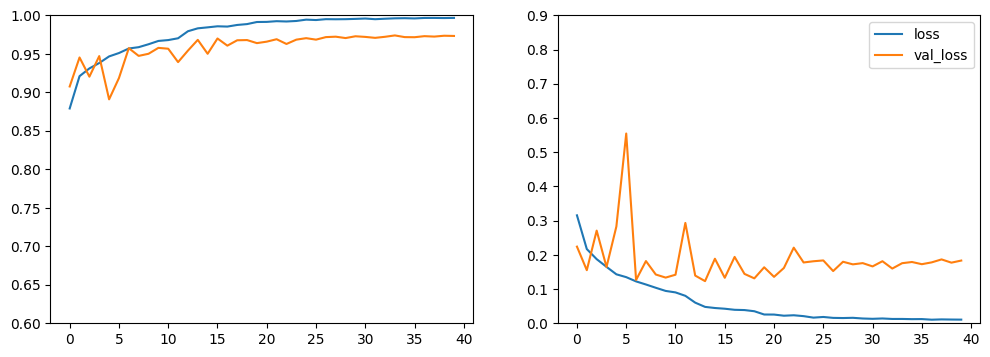

In [85]:
plot_history(history.history)

La curva di apprendimento con i class_weights è parzialmente sovrapponibile alla precedente, il che suggerisce che il modello non era particolarmente influenzato dallo sbilanciamento delle classi fin dall’inizio. L’andamento dell’accuracy di addestramento e validazione rimane molto simile: entrambe crescono rapidamente e poi si stabilizzano su valori alti, con la validazione che resta leggermente sotto ma in modo stabile. Anche la loss mostra lo stesso comportamento: quella di training scende in modo regolare fino a valori molto bassi, mentre quella di validazione mantiene la sua tipica oscillazione ma senza peggiorare e senza mostrare instabilità aggiuntiva dovuta ai pesi di classe.

In [86]:
y_pred_train = model.predict(X_train)

1141/1141 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step


In [87]:
y_pred_train = np.round(y_pred_train)

In [88]:
print(classification_report(y_train, y_pred_train, target_names=unique_macros))

              precision    recall  f1-score   support

      animal       1.00      1.00      1.00     23500
     vehicle       1.00      1.00      1.00     13000

    accuracy                           1.00     36500
   macro avg       1.00      1.00      1.00     36500
weighted avg       1.00      1.00      1.00     36500



In [131]:
y_pred_test_proba = model.predict(X_test)

229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step


In [132]:
y_pred_test = np.round(y_pred_test_proba)

In [133]:
print(classification_report(y_test, y_pred_test, target_names=unique_macros))

              precision    recall  f1-score   support

      animal       0.97      0.97      0.97      4700
     vehicle       0.95      0.94      0.95      2600

    accuracy                           0.96      7300
   macro avg       0.96      0.96      0.96      7300
weighted avg       0.96      0.96      0.96      7300



I risultati del classification report confermano pienamente ciò che si vede già nella learning curve: il modello impara molto bene entrambe le classi e mantiene una buona generalizzazione sul test, con un calo molto contenuto rispetto al dataset di allenamento. La performance sul dataset di allenamento è altissima per entrambe le classi e simmetrica, segno che la rete riesce a separare in modo molto netto gli esempi delle due categorie. Anche qui si nota un leggero abbassamento dell'accuratezza sul test set. 

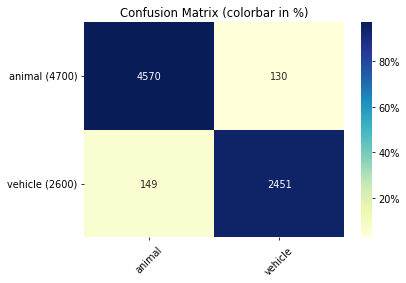

In [135]:
plot_confusion_matrix_colorbar_pct(y_test, y_pred_test, labels=unique_macros)

La confusion matrix conferma quanto emerge dal classification report. Rispetto all'allenamento senza class weight, si registra un leggero peggioramento delle prestazioni, in particolare sugli animali, i quali però rimangono leggermente più facili da classificare (0.97 di f1-score), mentre i veicoli mostrano un po’ più di variabilità e portano a una recall leggermente più bassa (0.94). Non emerge comunque un vero sbilanciamento del modello verso la classe più frequente. 

Non vi è quindi differenza sostanziale con l'introduzione dei class_weights. Questo è probabilmente segno che il modello, senza pesatura, aveva già trovato una frontiera di decisione molto vicina a quella ottimale. Lo sbilanciamento del dataset non influenzava in modo significativo l’apprendimento, poiché le due classi risultavano già facilmente separabili.

In [136]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_proba)
roc_auc = auc(fpr, tpr)

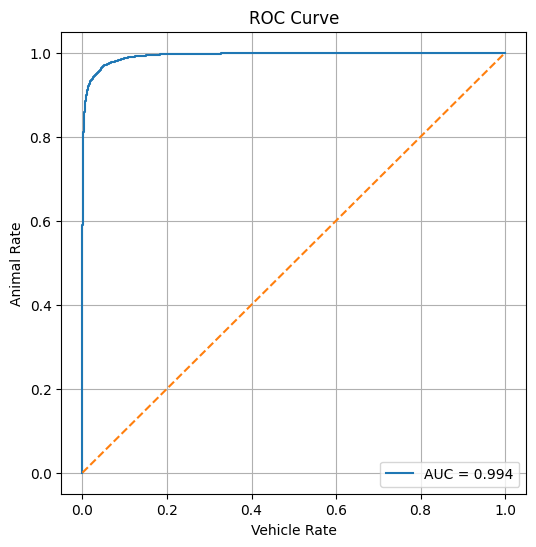

In [137]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')      # linea casuale
plt.xlabel('Vehicle Rate')
plt.ylabel('Animal Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

La ROC curve ottenuta dopo l’introduzione dei class weights appare praticamente sovrapponibile a quella del modello originale e conserva lo stesso valore di AUC pari a circa 0.994. Questo indica che la capacità discriminativa del modello non cambia in modo rilevante quando l’imbalance viene compensato artificialmente. La curva resta molto vicina all’angolo superiore sinistro, il profilo rimane verticale nella zona a falsi positivi bassissimi, e l’area sotto la curva rimane prossima al massimo teorico.



Le metriche hanno mostrato che la pesatura non modifica in alcun modo la sua capacità intrinseca di discriminazione, perché il problema non presentava un bias strutturale dovuto alla distribuzione dei dati. In questo contesto, l’imbalance è quindi ininfluente e i class weights non apportano alcun beneficio reale.

### Conclusioni

I risultati ottenuti indicano che il modello attuale rappresenta una soluzione adeguata ed equilibrata al problema affrontato. La rete, pur avendo una capacità relativamente contenuta, riesce a separare efficacemente le due classi raggiungendo un’accuratezza molto alta sia sul training sia sul test, con un divario minimo tra le prestazioni in addestramento e quelle in validazione. L’analisi dettagliata della learning curve mostra come il modello converga rapidamente verso un plateau stabile, suggerendo che la complessità del problema sia già pienamente catturata dall’architettura impiegata. Le ulteriori verifiche, condotte attraverso la confusion matrix e il classification report, confermano che lo sbilanciamento tra le classi non influisce in modo significativo sulle decisioni del modello.
L’uso dei pesi di classe non produce cambiamenti apprezzabili e le differenze tra precision, recall e f1-score delle due categorie rimangono contenute e non indicative di un bias strutturale.
In questo contesto, un aumento della capacità del modello può comportare un rischio più elevato di overfitting senza prospettare reali benefici in termini di generalizzazione: la rete attuale estrae già in maniera efficace tutta l’informazione utile contenuta nel dataset. Alla luce di queste evidenze, l’esplorazione di ulteriori strategie di bilanciamento o l’adozione di reti neurali con più parametri rischierebbero di aggiungere complessità senza offrire un guadagno significativo.